<a href="https://colab.research.google.com/github/prosvirinKir/rzd/blob/main/RNN_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pyreadr

     |████████████████████████████████| 419kB 26.0MB/s 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from datetime import datetime
sns.set(style="whitegrid", font_scale=1.4)
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from numpy import argmax
from tqdm import trange

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
import pyreadr
from tqdm.notebook import tqdm, trange

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
df = pyreadr.read_r("/content/gdrive/MyDrive/DLS/hw_segmentation/GOR.rds")

# Обработка исходных данных

In [5]:
df = df[None]
df = df.loc[:, (df != df.iloc[0]).any()] 
df = df.drop(df[df.TARGET_2 < 0].index)
pd.set_option("display.max_columns", 200)
df = df.drop(["KODOTS", "RASHIFROVKA", "PROVERENO", "PLUS", "STATUS", "CATEGORY", "KODNAPR", "UPDATTR", "TARGET_1", "TARGET_3"], axis=1)
df["AVG_BALL"] = df["AVG_BALL"].str.replace(',', '.')
df["AVG_KILO"] = df["AVG_KILO"].str.replace(',', '.')
df = df.drop(["LINE"], axis=1)
df = df.drop(['X2179_3', 'X2179_4', 'X2195_3', 'X2195_4', 'X2221_4'], axis = 1) # выкинул признаки, где одно значение

In [6]:
# df_saved = df.copy() # На случай, если в df будет какая-то лажа

In [7]:
# df = df_saved.copy()

In [8]:
df = df.sort_values(["KM", "YEAR", "MONTH", "DAY"])
target = df['TARGET_2']
year_col = df['YEAR']

# df_columns = df.columns

# Normalization
min_max_scaler = preprocessing.MinMaxScaler()
df.loc[:, :] = min_max_scaler.fit_transform(df)
df['TARGET_2'] = target.values

In [9]:
df.reset_index(inplace=True)
df = df.drop(['index'], axis=1)
df

,PCH,YEAR,MONTH,DAY,KM,M,BALL,SPEED_RES_PAS,SPEED_RES_FRE,SPEED_RES_EMPTY,SPEED_NORM_PAS,SPEED_NORM_FRE,LENGTH_KILO,RIX2,RIX3,RIX4,USH2,USH3,USH4,SUG2,SUG3,SUG4,PLU2,PLU3,PLU4,PER2,PER3,PER4,PRO2,PRO3,PRO4,OTS2,OTS3,OTS4,UKL,DRU,AVG_BALL,AVG_KILO,X2049_3,X2049_4,X2065_1,X2065_2,X2065_3,X2065_4,X2067_2,X2067_3,X2067_4,X2081_1,X2081_2,X2081_3,X2081_4,X2097_2,X2097_3,X2097_4,X2113_2,X2113_3,X2113_4,X2129_1,X2129_2,X2129_3,X2129_4,X2145_1,X2145_2,X2145_3,X2145_4,X2161_1,X2161_2,X2161_3,X2161_4,X2177_4,X2193_4,X2209_4,X2211_3,X2211_4,X2213_4,X2215_4,X2218_4,X2221_3,X2222_3,X2222_4,X2223_3,X2223_4,X2226_3,X2226_4,X2227_3,X2227_4,X2228_3,X2228_4,X2229_3,X2229_4,X2230_4,X2231_4,X2232_4,X2233_4,X2243_4,X2244_4,X2246_4,X2289_3,X2289_4,X2290_3,X2290_4,X2291_3,X2291_4,X3199_3,X3312_3,X3313_3,MISTAKES_GROUP,SPEED_RES_PAS_O,SPEED_RES_FRE_O,SPEED_NORM_PAS_O,SPEED_NORM_FRE_O,KR,DZ,T.,Z,IS,UR.PR,PRZH,X.,STRELKA,OBK,MOST,NR,ISM,PR_PREDUPR,EXCLUDE,TARGET_2,DIF_PAS_SP,DIF_FRE_SP,REPAIR_1,REPAIR_2,O_1,O_2,O_3,O_4,O_T,delta_OTS_2,delta_OTS_3,delta_OTS_4,delta_O_1,delta_O_2,delta_O_3,delta_O_4,delta_O_T
0,0.127660,0.000000,0.000000,0.600000,0.0,0.637765,0.0,1.0,1.0,1.0,0.35,0.777778,0.325894,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.498244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.00,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
1,0.127660,0.000000,0.090909,0.600000,0.0,0.638407,0.0,1.0,1.0,1.0,0.35,0.777778,0.325894,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.498244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.00,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0,0.5,0.5,0.000000,0.000000,0.0,0.0,0.000000,0.893560,0.978452,0.99403,0.935393,0.895161,0.89356,0.990089,0.852389
2,0.127660,0.000000,0.181818,0.633333,0.0,0.637765,0.0,1.0,1.0,1.0,0.35,0.777778,0.325894,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.498244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.00,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0,0.5,0.5,0.000000,0.000000,0.0,0.0,0.000000,0.893560,0.978452,0.99403,0.935393,0.895161,0.89356,0.990089,0.852389
3,0.127660,0.333333,0.454545,0.133333,0.0,0.638407,0.0,1.0,1.0,1.0,0.35,0.777778,0.325894,0.0,0.0,0.0,0.016529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010582,0.0,0.0,0.0,0.0,0.0,0.498244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.07,0.051020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0,0.0,0.0,0.000000,0.010417,0.0,0.0,0.010256,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
4,0.127660,0.333333,0.818182,0.833333,0.0,0.639049,0.0,1.0,1.0,1.0,0.35,0.777778,0.339022,0.0,0.0,

#Отбор признаков

Воспользуемся PCA, чтобы отобрать наиболее значимые признаки

In [10]:
N_FEATURES = 10 # hyperparameter

In [11]:
df_pca = df.drop(['TARGET_2', 'DAY', 'YEAR'], axis=1).copy()
pca_values = PCA(n_components=N_FEATURES).fit_transform(df_pca.values)
df_pca = pd.DataFrame(pca_values)

In [12]:
df_pca['DAY'] = df['DAY']
df_pca['MONTH'] = df['MONTH']
df_pca['YEAR'] = df['YEAR']
df_pca['KM'] = df['KM']
df_pca['TARGET_2'] = df['TARGET_2']

In [13]:
df_pca

,0,1,2,3,4,5,6,7,8,9,DAY,MONTH,YEAR,KM,TARGET_2
0,2.453763,0.960184,-0.794249,0.212638,0.068063,0.170765,-0.147498,0.059967,0.039024,-0.213989,0.600000,0.000000,0.000000,0.0,0
1,-0.222498,1.068257,-0.463912,0.113005,0.237547,-0.067704,0.080919,0.069147,0.030147,-0.253598,0.600000,0.090909,0.000000,0.0,0
2,-0.211544,1.071480,-0.378760,0.095948,0.258714,-0.075891,0.087953,0.069883,0.029850,-0.256638,0.633333,0.181818,0.000000,0.0,0
3,2.473477,-0.315279,-0.383690,-0.075684,0.265627,-0.016551,-0.190178,-0.003495,-0.043298,-0.156864,0.133333,0.454545,0.333333,0.0,0
4,-0.169909,-0.197598,0.202154,-0.226319,0.498569,-0.279566,0.059333,0.007799,-0.053173,-0.206616,0.833333,0.818182,0.333333,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107592,-0.297432,-0.256643,-0.316446,-0.013946,-0.592297,-0.160090,0.138220,-0.200847,-0.182310,0.110746,0.600000,0.000000,1.000000,1.0,0
107593,-0.262576,1.007032,-0.300618,0.186936,-0.682101,-0.016158,0.215243,-0.131064,-0.106249,0.037334,0.933333,0.000000,1.000000,1.0,0
107594,-0.251052,1.010223,-0.215504,0.169909,-0.660959,-0.024194,0.222180,-0.130346,-0.106559,0.034242,0.900000,0.090909,1.000000,1.0,0
107595,-0.405267,-0.280756,0.011411,-0.050652,-0.507852,0.240922,-0.046671,-0.217861,-0.163167,0.108450,0.600000,0.272727,1.000000,1.0,0


# Подготовка данных
Данные представляют собой последовательные (заранее отсортированные) наблюдения для *текущего* километра дороги. Для каждого километра их в среднем около 70 штук. 

Т.к. для рекуррентных сетей важно не только текущее наблюдение, но и его предыстория, мы идем "окном" по всем этим наблюдениям. Размер "окна" задается гиперпараметром HISTORY_SIZE. 

Таким образом, эдементарный "кусок" данных, который подается на вход рекуррентной сети, содержит HISTORY_SIZE наблюдений. Каждое наблюдение представялет собой вектор длины FEATURE_NUM - еще один гиперпараметр.

In [14]:
# Размер окна
HISTORY_SIZE = 10 # лучше не ставить больше 20

# Шаг окна
STEP = 1

In [15]:
# Здесь для удобства задаем data frame, с которым будем работать
data_frame = df_pca 

# Сортируем по километрам, а каждый километр по дате
data_frame = data_frame.sort_values(["KM", "YEAR", "MONTH", "DAY"])

train_val_df = data_frame[year_col.values < 2020]
test_df = data_frame[year_col.values >= 2020]

In [16]:
# sum(test_df.groupby('KM').aggregate('count')['MONTH'] < HISTORY_SIZE) # сколько км с < измерением

In [17]:
# Удаляю ненужные признаки
train_val_df = train_val_df.drop(['YEAR', 'DAY'], axis=1)
test_df = test_df.drop(['YEAR', 'DAY'], axis=1)

In [18]:
def make_shuffled(X, y):

    # Кол-во объектов
    n_samples = X.shape[0]

    data = torch.utils.data.DataLoader(list(zip(X, y)), batch_size=n_samples, shuffle=True)

    for X_batch, y_batch in data:
        X_shuffled = X_batch
        y_shuffled = y_batch
    
    return X_shuffled, y_shuffled

In [19]:
def make_data(data_frame):

    # Отсортированный список всех километров
    KM_unique = sorted(data_frame.KM.unique())

    # Т.к. в pytorch нет функции append, приходится стакать на нулевые тензоры 
    train = torch.zeros((1, HISTORY_SIZE, data_frame.shape[1]))
    label = torch.zeros((1))
    for km in tqdm(KM_unique):

      df_km = data_frame[data_frame['KM'] == km]

      # Не сдвинутые таргеты
      y_km = df_km['TARGET_2'].values 

      # Сдвигаем все таргеты на один вниз
      df_km['TARGET_2'] = np.hstack((0, y_km[:-1]))

      # Создаем набор данных для каждого км
      cur_km = 0
      max_iter = df_km.shape[0]
      while max_iter >= cur_km + HISTORY_SIZE:

          train_km = df_km.iloc[cur_km:cur_km + HISTORY_SIZE].to_numpy(dtype=np.float16)
          train_km = torch.FloatTensor(train_km)
          train = torch.vstack((train, train_km.unsqueeze(0)))
          label = torch.vstack((label, torch.tensor(y_km[cur_km + HISTORY_SIZE - 1])))
          cur_km += STEP

    return train, label

# Обучение

In [20]:
X, y = make_data(train_val_df)

In [21]:
X, y = make_shuffled(X, y)

In [22]:
y = y.long()

In [188]:
X_test, y_test = make_data(test_df)

In [189]:
X_test.shape

torch.Size([3420, 10, 13])

In [25]:
# Сохраним данные
torch.save(X, f'train_val_hist_{HISTORY_SIZE}_nf_{N_FEATURES}.pt')
torch.save(y, f'train_val_label_hist_{HISTORY_SIZE}_nf_{N_FEATURES}.pt')

torch.save(X_test, f'test_hist_{HISTORY_SIZE}_nf_{N_FEATURES}.pt')
torch.save(y_test, f'test_label_hist_{HISTORY_SIZE}_nf_{N_FEATURES}.pt')

In [26]:
# X = torch.load('train_val_hist_10_nf_20.pt')
# y = torch.load('train_val_label_hist_10_nf_20.pt')
# X_test = torch.load('test_hist_10_nf_10.pt')
# y_test = torch.load('test_label_hist_10_nf_10.pt')

In [27]:
# Объем выборки (кол-во тех самых окошков)
n_samples = X.shape[0]

# Какая часть пойдет в трейн
alpha = 0.8
to_blade = int(n_samples * alpha)

In [28]:
n_samples, to_blade

(78209, 62567)

In [29]:
train_dl = torch.utils.data.DataLoader(list(zip(X[:to_blade], y[:to_blade])), batch_size=512)
valid_dl = torch.utils.data.DataLoader(list(zip(X[to_blade:], y[to_blade:])), batch_size=512, drop_last=True)
test_dl = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=512, drop_last=True)

In [30]:
def training(model, criterion, optimizer, num_epochs, train_dl, valid_dl, scheduler, max_grad_norm=2):
    val_losses = []

    for e in trange(num_epochs, leave=False):
        scheduler.step
        model.train()
        num_iter = 0
        pbar = tqdm(train_dl, leave=False)
        for X_batch, y_batch in pbar:
            optimizer.zero_grad()
            input_embeds = X_batch.to(device)
            labels = y_batch.to(device).flatten()
            prediction = model(input_embeds)
            loss = criterion(prediction, labels)
            loss.backward()
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            num_iter += 1
        valid_loss = 0
        valid_score = 0
        num_iter = 0
        model.eval()
        with torch.no_grad():
            correct = 0
            num_objs = 0
            for X_batch, y_batch in valid_dl:
                input_embeds = X_batch.to(device)
                labels = y_batch.to(device).flatten()
                prediction = model(input_embeds)
                valid_loss += criterion(prediction, labels)
                # print(y_batch)
                # print(prediction[:5,1])
                # print("y_batch =", y_batch.flatten())
                valid_score += roc_auc_score(y_batch, prediction[:,1].detach().cpu().numpy())
                # print(valid_score)
                num_iter += 1
        val_losses.append(valid_loss / num_iter)
        print(f"Valid Loss: {valid_loss / num_iter}, mean_roc_auc: {valid_score / num_iter}")
    return val_losses

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# RNN model

Модель RNN описывается следующим образом::

$$
h_t = \tanh(W_{ih} x_t + b_{ih} + W_{hh} h_{(t-1)} + b_{hh})
$$

In [32]:
class RNN(nn.Module):
    def __init__(self, embed_size, hidden_size):
        super().__init__()

        self.embed_size = embed_size
        self.hidden_size = hidden_size

        self.w_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_x = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_x = nn.Parameter(torch.rand(1, hidden_size))

    def forward(self, x, hidden=None):
        '''
        x – torch.FloatTensor with the shape (bs, seq_length, emb_size)
        hidden - torch.FloatTensro with the shape (bs, hidden_size)
        return: torch.FloatTensor with the shape (bs, hidden_size)
        '''
        if hidden is None:
            hidden = torch.zeros((x.size(0), self.hidden_size)).to(x.device)
        seq_length = x.size(1)
        for cur_idx in range(seq_length):
            hidden = torch.tanh(
                x[:, cur_idx] @ self.w_x + self.b_x + hidden @ self.w_h + self.b_h
            )
        return hidden

In [33]:
class RNNModel(nn.Module):
    def __init__(self, embed_size, hidden_size, num_classes=2):
        super().__init__()
        self.rnn = RNN(embed_size, hidden_size)
        self.cls = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        hidden = self.rnn(x)
        hidden = self.cls(hidden)
        return hidden

In [173]:
num_features = len(list(train_val_df))
n_hidden = len(list(train_val_df))

rnn_model = RNNModel(num_features, n_hidden).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)

num_epochs = 60
max_grad_norm = 1.0

In [ ]:
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
val_losses = training(rnn_model, criterion, optimizer, num_epochs, train_dl, valid_dl, exp_lr_scheduler, max_grad_norm)

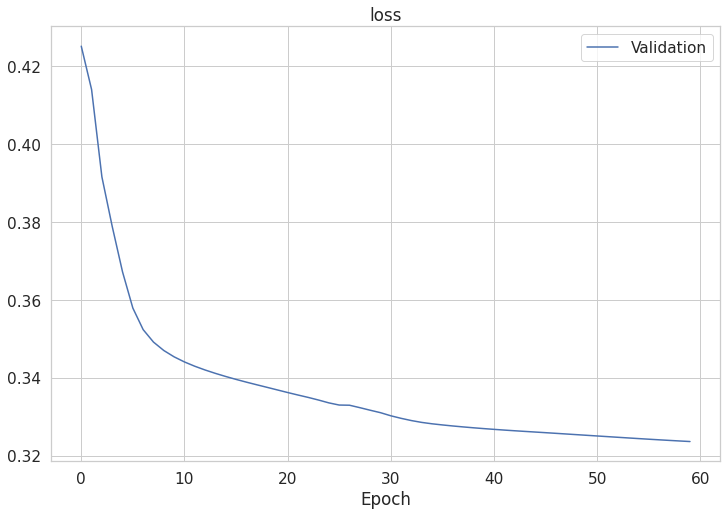

In [177]:
plt.figure(figsize=(12, 8))
# plt.plot(np.arange(len(train_losses) - 1), train_losses[1:], label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('loss')
plt.legend()
plt.show()

In [178]:
X_valid = X[to_blade:]
y_valid = y[to_blade:]

In [179]:
preds = rnn_model(X_valid.to(device)).detach().cpu().numpy()
preds.shape

(15642, 2)

In [180]:
test_auc = roc_auc_score(y[to_blade:], preds[:,1])
test_auc

0.8298278062702588

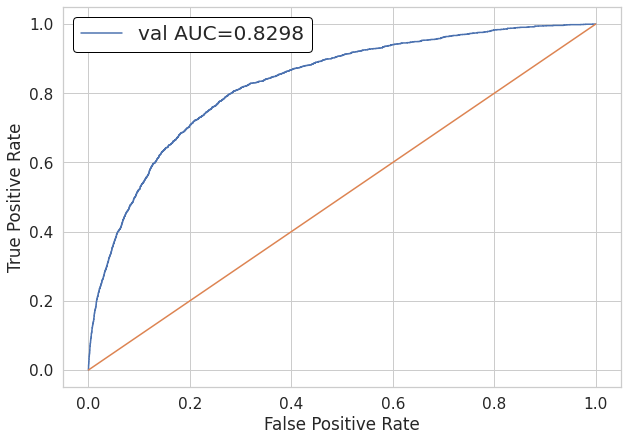

In [182]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_valid, preds[:,1])[:2], label='val AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
# plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# GRU model

Модель GRU описывается следующим образом:

$$
\begin{array}{ll}
            r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
            z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
            n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
            h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
        \end{array}
$$

In [41]:
class GRU(nn.Module):
    def __init__(self, embed_size, hidden_size):
        super().__init__()

        self.embed_size = embed_size
        self.hidden_size = hidden_size

        self.w_rh = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_rh = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_rx = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_rx = nn.Parameter(torch.rand(1, hidden_size))

        self.w_zh = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_zh = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_zx = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_zx = nn.Parameter(torch.rand(1, hidden_size))

        self.w_nh = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_nh = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_nx = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_nx = nn.Parameter(torch.rand(1, hidden_size))

    def forward(self, x, hidden = None):
        '''
        x – torch.FloatTensor with the shape (bs, seq_length, emb_size)
        hidden - torch.FloatTensro with the shape (bs, hidden_size)
        return: torch.FloatTensor with the shape (bs, hidden_size)
        '''
        if hidden is None:
            hidden = torch.zeros((x.size(0), self.hidden_size)).to(x.device)
        
        for cur_idx in range(x.size(1)):
            r = torch.sigmoid(
                x[:, cur_idx] @ self.w_rx + self.b_rx + hidden @ self.w_rh + self.b_rh
            )
            z = torch.sigmoid(
                x[:, cur_idx] @ self.w_zx + self.b_zx + hidden @ self.w_zh + self.b_zh
            )
            n = torch.tanh(
                x[:, cur_idx] @ self.w_nx + self.b_nx + r * (hidden @ self.w_nh + self.b_nh)
            )
            hidden = (1 - z) * n + z * hidden

        return hidden

In [42]:
class GRUModel(nn.Module):
    def __init__(self, embed_size, hidden_size, num_classes=2):
        super().__init__()
        self.gru = GRU(embed_size, hidden_size)
        self.cls = nn.Linear(hidden_size, num_classes)
        # self.softmax = nn.Softmax()

    def forward(self, x):
        hidden = self.gru(x)
        hidden = self.cls(hidden)
        # hidden = self.softmax(hidden)
        return hidden

In [167]:
num_features = len(list(train_val_df))
n_hidden = len(list(train_val_df))

gru_model = GRUModel(num_features, n_hidden).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=1e-3)

num_epochs = 60
max_grad_norm = 1.0

In [168]:
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
val_losses = training(gru_model, criterion, optimizer, num_epochs, train_dl, valid_dl, exp_lr_scheduler, max_grad_norm)

Valid Loss: 0.42890605330467224, mean_roc_auc: 0.5651211377767194


Valid Loss: 0.4169214963912964, mean_roc_auc: 0.618687059452684


Valid Loss: 0.41101783514022827, mean_roc_auc: 0.6480755121139289


Valid Loss: 0.3992650508880615, mean_roc_auc: 0.6843329637864825


Valid Loss: 0.3874061703681946, mean_roc_auc: 0.7142978748061501


Valid Loss: 0.3775584399700165, mean_roc_auc: 0.7404302692860983


Valid Loss: 0.36730897426605225, mean_roc_auc: 0.7637178400287876


Valid Loss: 0.3575308322906494, mean_roc_auc: 0.7802882522726973


Valid Loss: 0.3485964238643646, mean_roc_auc: 0.7932986112152565


Valid Loss: 0.3419366180896759, mean_roc_auc: 0.8024249650162448


Valid Loss: 0.3371110260486603, mean_roc_auc: 0.8091245038110386


Valid Loss: 0.3336655795574188, mean_roc_auc: 0.8140448891132886


Valid Loss: 0.3312270939350128, mean_roc_auc: 0.8178811818319572


Valid Loss: 0.3295195400714874, mean_roc_auc: 0.8204513903773365


Valid Loss: 0.32829514145851135, mean_roc_auc: 0.8225374576332511


Valid Loss: 0.3273589611053467, mean_roc_auc: 0.8240322563603901


Valid Loss: 0.3265879452228546, mean_roc_auc: 0.8251810357475499


Valid Loss: 0.32591402530670166, mean_roc_auc: 0.8263341827574141


Valid Loss: 0.32530221343040466, mean_roc_auc: 0.8272827356822521


Valid Loss: 0.32473674416542053, mean_roc_auc: 0.8281531370653246


Valid Loss: 0.3242115378379822, mean_roc_auc: 0.8287739858759179


Valid Loss: 0.32372477650642395, mean_roc_auc: 0.829345365298668


Valid Loss: 0.32327476143836975, mean_roc_auc: 0.8299185187492779


Valid Loss: 0.3228594660758972, mean_roc_auc: 0.8305339969850684


Valid Loss: 0.32247763872146606, mean_roc_auc: 0.831197658994747


Valid Loss: 0.3221282660961151, mean_roc_auc: 0.8315128910405268


Valid Loss: 0.32181039452552795, mean_roc_auc: 0.8319147075260201


Valid Loss: 0.32152238488197327, mean_roc_auc: 0.8323546284693973


Valid Loss: 0.3212621212005615, mean_roc_auc: 0.8327345322560802


Valid Loss: 0.32102715969085693, mean_roc_auc: 0.8330860892423296


Valid Loss: 0.32081472873687744, mean_roc_auc: 0.8333426172573165


Valid Loss: 0.32062214612960815, mean_roc_auc: 0.8336000066700456


Valid Loss: 0.32044726610183716, mean_roc_auc: 0.8339208177060498


Valid Loss: 0.32028788328170776, mean_roc_auc: 0.8341642518107599


Valid Loss: 0.32014229893684387, mean_roc_auc: 0.8344133795059743


Valid Loss: 0.3200089931488037, mean_roc_auc: 0.8346412731884317


Valid Loss: 0.31988659501075745, mean_roc_auc: 0.8348054725678917


Valid Loss: 0.3197738826274872, mean_roc_auc: 0.8349156604170613


Valid Loss: 0.3196698725223541, mean_roc_auc: 0.8350601997748072


Valid Loss: 0.3195735514163971, mean_roc_auc: 0.8351659484271191


Valid Loss: 0.31948405504226685, mean_roc_auc: 0.8353279742225282


Valid Loss: 0.3194005489349365, mean_roc_auc: 0.8354402476395832


Valid Loss: 0.31932222843170166, mean_roc_auc: 0.8355155279405717


Valid Loss: 0.3192484974861145, mean_roc_auc: 0.8356057141121875


Valid Loss: 0.3191785216331482, mean_roc_auc: 0.8356705312298133


Valid Loss: 0.31911197304725647, mean_roc_auc: 0.8358099450359462


Valid Loss: 0.31904828548431396, mean_roc_auc: 0.8359222613439206


Valid Loss: 0.3189871609210968, mean_roc_auc: 0.8360072655077745


Valid Loss: 0.3189283311367035, mean_roc_auc: 0.8360771684049292


Valid Loss: 0.3188716471195221, mean_roc_auc: 0.8361020278585107


Valid Loss: 0.31881678104400635, mean_roc_auc: 0.8361111316820339


Valid Loss: 0.3187636733055115, mean_roc_auc: 0.8361937030545961


Valid Loss: 0.31871241331100464, mean_roc_auc: 0.8362535212425937


Valid Loss: 0.31866249442100525, mean_roc_auc: 0.8362866974775395


Valid Loss: 0.31861412525177, mean_roc_auc: 0.8363633285433465


Valid Loss: 0.31856703758239746, mean_roc_auc: 0.8364715517285484


Valid Loss: 0.31852126121520996, mean_roc_auc: 0.8365377335877809


Valid Loss: 0.3184766471385956, mean_roc_auc: 0.8365790161702739


Valid Loss: 0.31843310594558716, mean_roc_auc: 0.8366355204102338


Valid Loss: 0.3183906078338623, mean_roc_auc: 0.8366792373098982


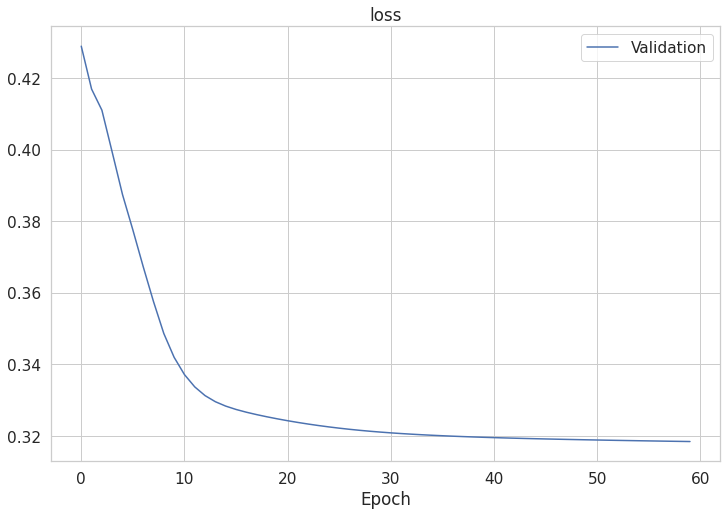

In [169]:
plt.figure(figsize=(12, 8))
# plt.plot(np.arange(len(train_losses) - 1), train_losses[1:], label='Train')
plt.plot(np.arange(len(val_losses) ), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('loss')
plt.legend()
plt.show()

In [170]:
preds = gru_model(X_valid.to(device)).detach().cpu().numpy()
preds.shape

(15642, 2)

In [171]:
test_auc = roc_auc_score(y_valid, preds[:,1])
test_auc

0.8349566279549825

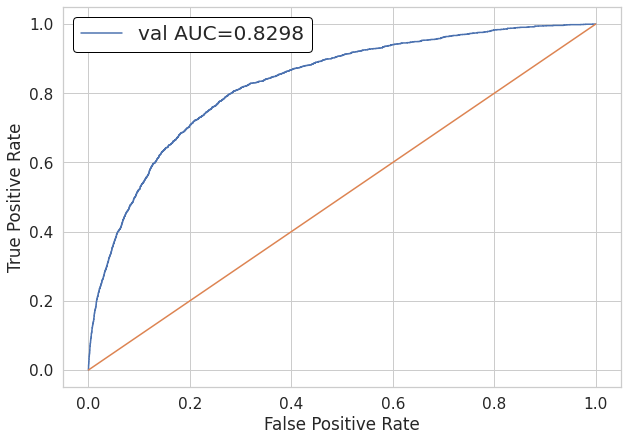

In [183]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_valid, preds[:,1])[:2], label='val AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
# plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Тест

In [193]:
rnn_preds = rnn_model(X_test.to(device)).detach().cpu().numpy()
rnn_preds.shape

(3420, 2)

In [194]:
def make_graph(y_true, y_pred, model_name):
  
    test_auc = roc_auc_score(y_true, y_pred[:,1])
    fpr, tpr, thresholds = roc_curve(y_true, y_pred[:,1])
    tnr = 1 - fpr
    # best_thresh = min(thresholds[abs(tpr - tnr) < 1e-2])

    balanced_accuracy = (tpr + tnr) / 2
    best_thresh_index = np.where(balanced_accuracy == max(balanced_accuracy))[0]
    best_thresh = thresholds[best_thresh_index]
    
    plt.figure(figsize=(10,7))
    plt.plot(fpr, tpr, label='test AUC={:.4f}'.format(test_auc))
    legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
    # plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
    plt.title(model_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    plt.figure(figsize=(10,7))
    plt.plot(thresholds, balanced_accuracy, label='Balanced accuracy')
    plt.plot(best_thresh, balanced_accuracy[best_thresh_index], marker='o', color='black', label=f'best_threshold={best_thresh[0]:.2f}')
    plt.ylabel('Balanced accuracy')
    plt.xlabel('Threshold')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,7))
    plt.plot(thresholds, tpr, label='True Positive Rate')
    plt.plot(thresholds, 1-fpr, label='False Positive Rate')
    plt.plot(best_thresh, tpr[best_thresh_index], marker='o', color='black', label=f'best_threshold={best_thresh[0]:.2f}')
    plt.ylabel('True Positive Rate')
    plt.xlabel('Threshold')
    plt.legend()
    plt.show()

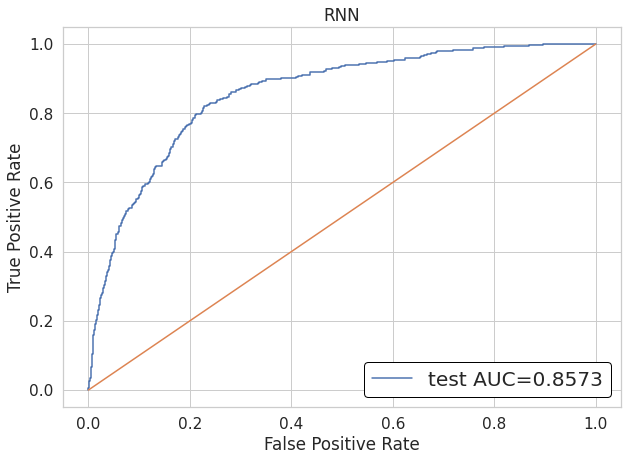

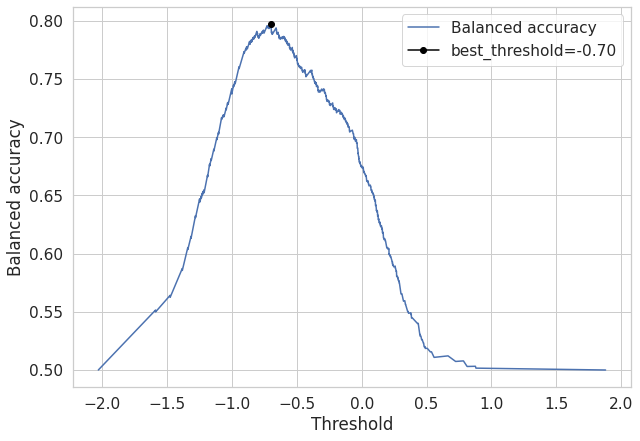

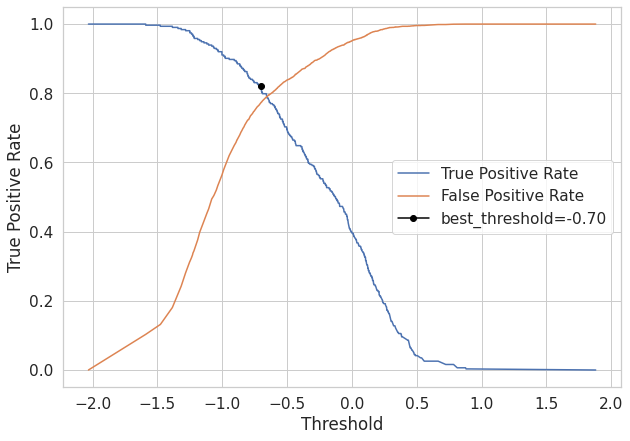

In [195]:
make_graph(y_test, rnn_preds, 'RNN')

In [196]:
gru_preds = gru_model(X_test.to(device)).detach().cpu().numpy()
gru_preds.shape

(3420, 2)

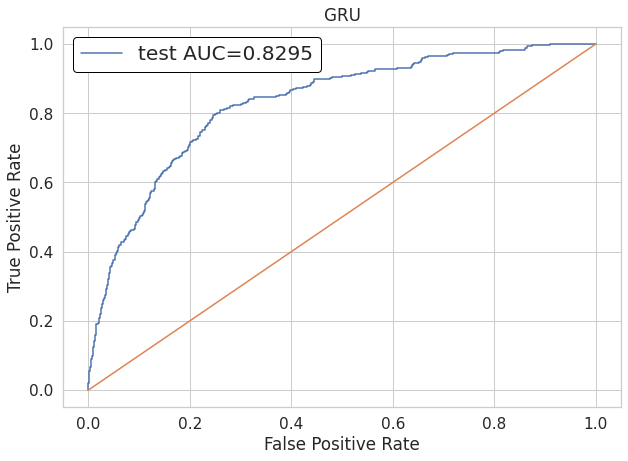

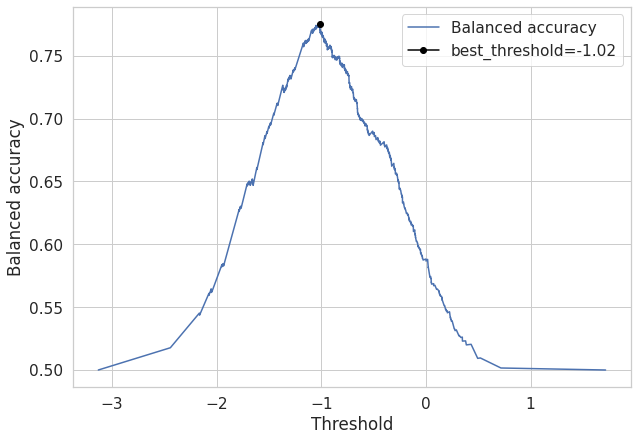

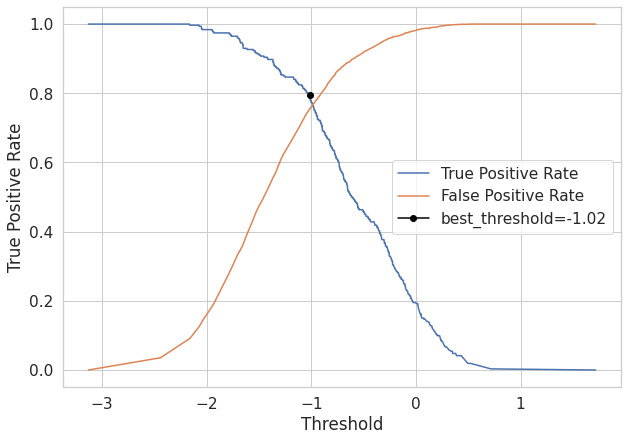

In [197]:
make_graph(y_test, gru_preds, 'GRU')